In [5]:
import os
import torch
from model import ForgeryDetector
from tqdm import tqdm
from metrics import region_consistency_metric

# 画像サイズ
H = 128 
W = 128 
C = 3 
# 学習結果の保存先フォルダ
MODEL_DIR = './defacto_models/'
MODEL_FILE = os.path.join(MODEL_DIR, 'forgery_detector_model.pth')

In [2]:
# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
model = ForgeryDetector(C=C, H=H, W=W)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

In [3]:
from torch.utils.data import DataLoader
from mylib.data_io import TensorDataset


RESTART_MODE = False
BATCH_SIZE = 100
DATA_DIR = './Datasets/'
TEST_INPUT_IMAGES_FILE   = 'defacto_test_input_images.pt'
TEST_TARGET_IMAGES_FILE  = 'defacto_test_target_images.pt'

# テンソルファイルを読み込み, 訓練データセットを用意
if RESTART_MODE:
    test_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', TEST_INPUT_IMAGES_FILE),
        os.path.join('./temp/', TEST_TARGET_IMAGES_FILE)
    ])
else:
    test_dataset = TensorDataset(filenames=[
        os.path.join(DATA_DIR, TEST_INPUT_IMAGES_FILE),
        os.path.join(DATA_DIR, TEST_TARGET_IMAGES_FILE)
    ])
test_size = len(test_dataset)

# テストデータをミニバッチに分けて使用するための「データローダ」を用意
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

100%|██████████| 10/10 [00:00<00:00, 14.22it/s]


recall = 0.307118
precision = 0.275103
IoU = 0.127517



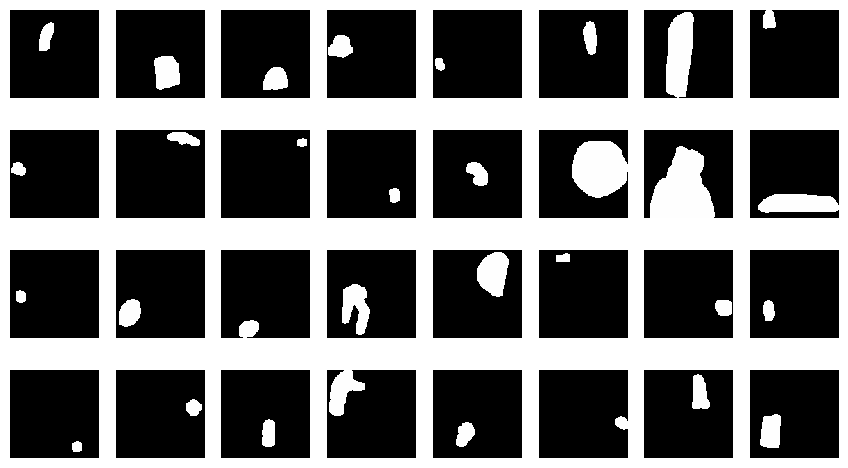

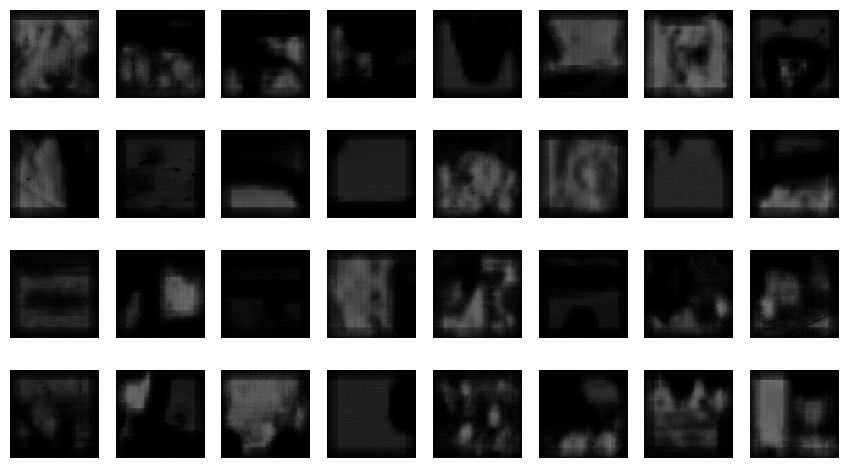

In [6]:
import torch
from mylib.data_io import show_images

DEVICE = 'cuda:0'
USE_AMP = True
FLOAT_DTYPE = torch.float16 

model = model.to(DEVICE)
model.eval()

# テストデータセットで精度を評価
sum_recall = 0
sum_precision = 0
sum_IoU = 0
with torch.inference_mode():
    for X, Y in tqdm(test_dataloader):
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # 正解のマスク画像
        with torch.amp.autocast_mode.autocast(enabled=USE_AMP, device_type='cuda', dtype=FLOAT_DTYPE):
            Y_pred = model(X)
        recall, precision, IoU = region_consistency_metric(Y_pred.to(torch.float32), Y)
        sum_recall += recall * len(X)
        sum_precision += precision * len(X)
        sum_IoU += IoU * len(X)
avg_recall = sum_recall / test_size
avg_precision = sum_precision / test_size
avg_IoU = sum_IoU / test_size
print('recall = {0:.6f}'.format(avg_recall))
print('precision = {0:.6f}'.format(avg_precision))
print('IoU = {0:.6f}'.format(avg_IoU))
print('')

# 推定結果の例を表示
show_images(Y.to('cpu').detach(), num=32, num_per_row=8, title='ground truth', save_fig=False, save_dir=MODEL_DIR)
show_images(Y_pred.to('cpu').detach(), num=32, num_per_row=8, title='estimated', save_fig=False, save_dir=MODEL_DIR)